## 3.7 
Provide a guideline on how many genes are necessary to identify most cell subsets and their expression variation within a tissue. 

In [1]:
# Experiment: iteratively subset the selected set of genes, train cell type classifiers, and measure classification performance.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RES_DIR = "/Users/louis.kuemmerle/Promotion/projects/G1/results/spapros_smk_res_bm"

In [3]:
df_eval = pd.read_csv(Path(RES_DIR, "evaluation_overview.csv"),index_col=0)
df_data = pd.read_csv(Path(RES_DIR, "data_parameters.csv"),index_col=0)
df_sele = pd.read_csv(Path(RES_DIR, "selection_overview.csv"),index_col=0).set_index("selection_name")

df_eval["ct_key"] = df_eval["eval_data_id"].apply(lambda x: df_data.loc[x,"ct_key"])


In [4]:
SELECTION_BATCH = 'batchQ3.7'
EVAL_BATCH_SPATIAL = 'eval_batch_Q3.7'
EVAL_BATCH_SN = 'eval_batch_Q3.7_sn_2' # NOTE: updated eval cell type, previously was 'eval_batch_Q3.7_sn' 


In [5]:
CT_KEY_SPATIAL = "clean_type" # "cluster_L3"
CT_KEY_SN = "subclass_label" #"celltype"

summary_file_spatial = df_eval.loc[
    (df_eval["eval_dataset"] == "merfish_MTG_no_vessels") &
    (df_eval["eval_batch"] == EVAL_BATCH_SPATIAL) &
    (df_eval["ct_key"] == CT_KEY_SPATIAL),
    "eval_summary_file"
].unique()[0]
summary_file_sn = df_eval.loc[
    (df_eval["eval_dataset"] == "2019Hodge_sn_human_brain_MTG_min20perct") &
    (df_eval["eval_batch"] == EVAL_BATCH_SN) &
    (df_eval["ct_key"] == CT_KEY_SN),
    "eval_summary_file"
].unique()[0]

df_metrics_spatial = pd.read_csv(Path(RES_DIR, summary_file_spatial), index_col=0)
df_metrics_spatial["modality"] = "spatial"
df_metrics_sn = pd.read_csv(Path(RES_DIR, summary_file_sn), index_col=0)
df_metrics_sn["modality"] = "sn"

df_metrics = pd.concat([df_metrics_spatial, df_metrics_sn])

df_sele = df_sele.loc[df_sele["batch"] == SELECTION_BATCH]
selections = df_sele.index.tolist()
df_metrics = df_metrics.loc[selections]
df_metrics["n"] = df_sele.loc[df_metrics.index,"n"].values
df_metrics["method"] = df_metrics.index.str.split("_").str[0]


In [6]:
metric_to_label = {
    'score': 'score',
    'var score': 'variation recovery score',
    'cluster_similarity nmi_5_20': 'coarse clustering similarity',
    'cluster_similarity nmi_21_60': 'fine clustering similarity',
    'knn_overlap mean_overlap_AUC': 'neighborhood similarity',
    'ct score': 'cell type classif. score',
    'forest_clfs accuracy': 'cell type classif. acc.',
    'forest_clfs perct acc > 0.8': 'perct. of captured cell types',
    'moranI': "spatial variation (Moran's I)",
    'moranI ct max': 'within cell type spatial variation',
    # 'moranI ct mean'                :'',
}


def plot_metric_with_std(data, metric='forest_clfs accuracy', n_stds=2, figsize=(5, 3), save=False):
    """
    Plots the mean of 'forest_clfs accuracy' against 'n' and fills between 
    mean +/- standard deviation.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the data.
    """
    
    fig = plt.figure(figsize=figsize)
    
    modalities = data['modality'].unique()

    for i, modality in enumerate(modalities):

        data_ = data.loc[data['modality'] == modality]

        # Group by 'n' and calculate mean and std for 'forest_clfs accuracy'
        # Group by 'n' and calculate mean and std for 'forest_clfs accuracy'
        grouped_data = data_.groupby('n')[metric].agg(['mean', 'std', 'count'])
        
        # Calculate SEM
        grouped_data['sem'] = grouped_data['std'] / (grouped_data['count'] ** 0.5)
    
        # Plotting
        
        plt.plot(grouped_data.index, grouped_data['mean'], label=modality, linestyle='-') #, marker='o'
        plt.fill_between(grouped_data.index, 
                         grouped_data['mean'] - n_stds * grouped_data['std'], #grouped_data['sem'], 
                         grouped_data['mean'] + n_stds * grouped_data['std'], #grouped_data['sem'], 
                         color='gray', alpha=0.2, label=None if i < (len(modalities)-1) else '2 std. deviation')

    plt.xlabel('n selected genes')
    plt.xscale("log")
    plt.ylabel(metric_to_label[metric])
    #plt.title('Forest Clfs Accuracy vs n')
    plt.legend()
    plt.grid(True)
    #plt.xscale("log")
    if save:
        fig.savefig(save, bbox_inches='tight', transparent=True)
    plt.show()


In [7]:
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 300  # 150
plt.rcParams['savefig.dpi'] = 300  # 150
SMALL_SIZE = 9  # 17
MEDIUM_SIZE = 11  # 19
BIGGER_SIZE = 13  # 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [8]:
cols = ["knn_overlap mean_overlap_AUC", "forest_clfs accuracy", "forest_clfs perct acc > 0.8", "n"]
df_metrics.loc[df_metrics["modality"]=="sn",cols].groupby("n").mean()

,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8
n,,,
2,0.002080,0.358162,0.094562
5,0.022865,0.690651,0.379965
10,0.048279,0.856995,0.756672
15,0.062198,0.911455,0.913624
20,0.074253,0.934764,0.933206
30,0.093109,0.946865,0.933333
50,0.117559,0.954739,0.933333
75,0.129620,0.958254,0.933333
100,0.163834,0.957681,0.933333


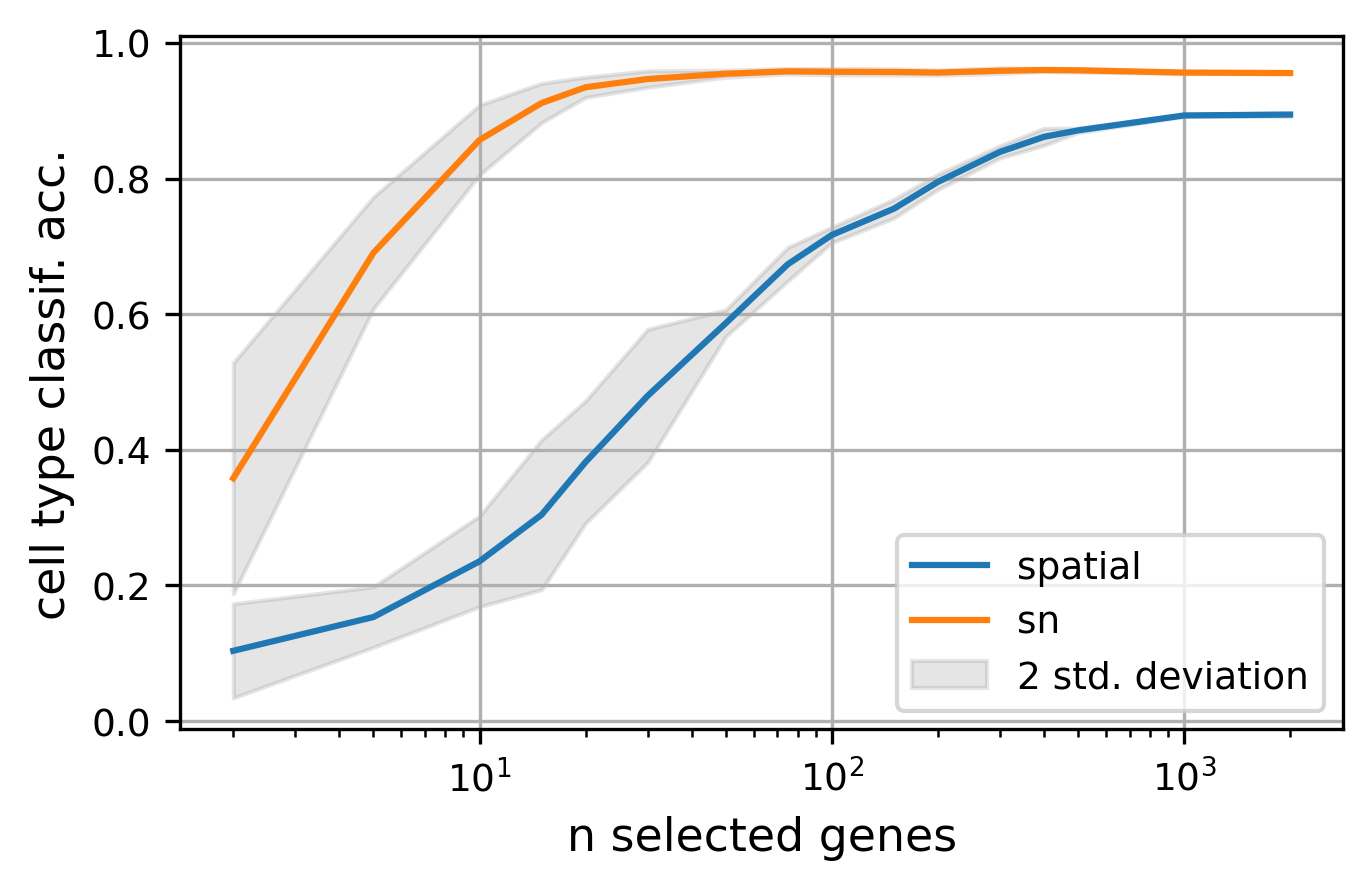

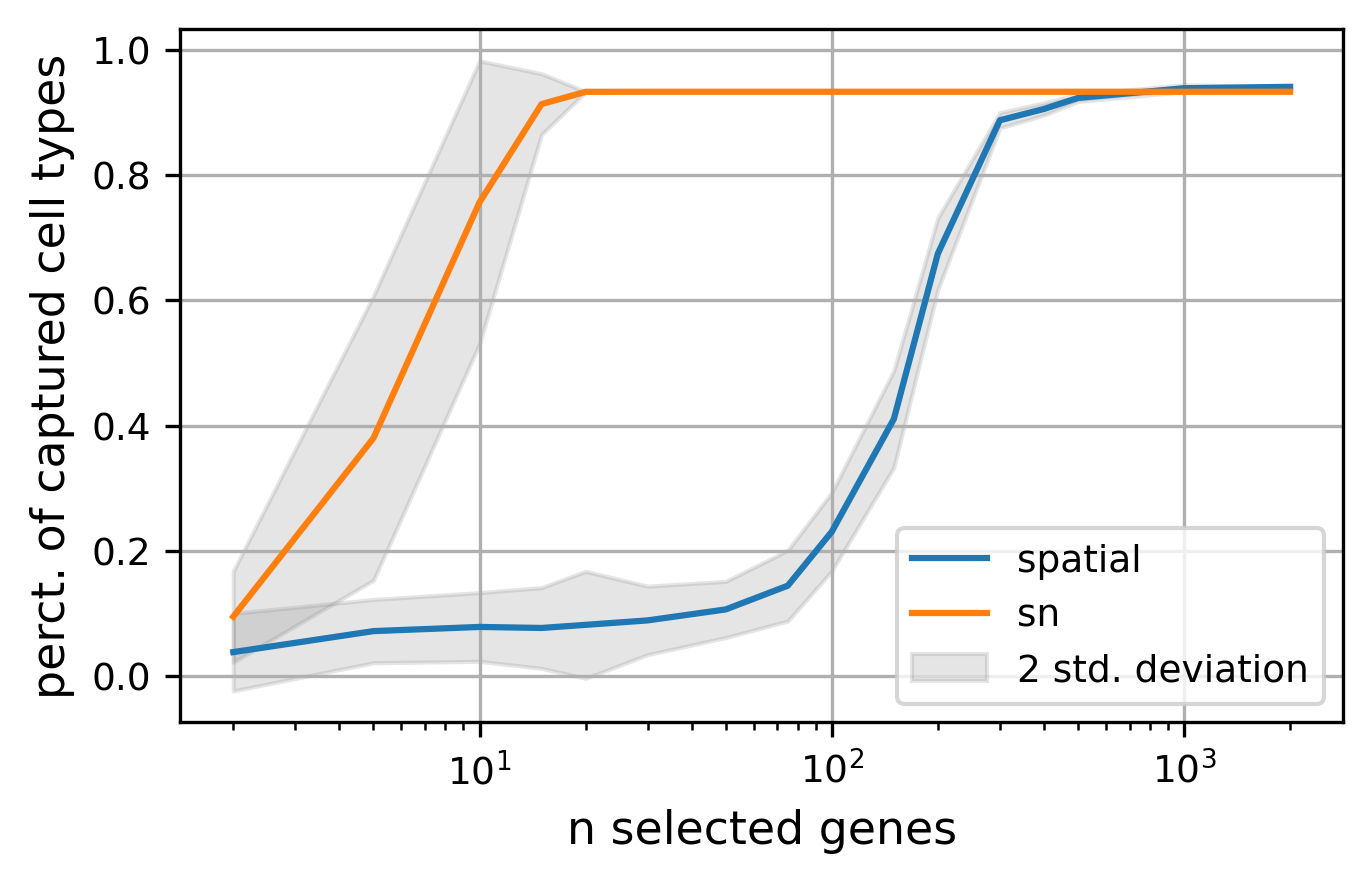

In [9]:
plot_metric_with_std(df_metrics, metric='forest_clfs accuracy', save="./figures/Q3_7_forest_clfs_accuracy_vs_n.pdf")
plot_metric_with_std(df_metrics, metric='forest_clfs perct acc > 0.8', save="./figures/Q3_7_perc_captured_cts_vs_n.pdf")


In [18]:
print(30 / 15)
print(50 / 15)
print(400 / 17)
print(1000 / 17)

2.0
3.3333333333333335
23.529411764705884
58.8235294117647
